<a href="https://colab.research.google.com/github/animeesh/deep-learning/blob/master/Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7db71598-2f7c-fcf0-abc9-bb36465b5333)


In [2]:
#getting helper function from github

!wget https://raw.githubusercontent.com/animeesh/deep-learning/master/helper.py

--2021-08-28 01:59:37--  https://raw.githubusercontent.com/animeesh/deep-learning/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper.py.5’

helper.py.5         100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-28 01:59:37 (103 MB/s) - ‘helper.py.5’ saved [10246/10246]



In [3]:
from helper import create_tensorboard_callback,plot_loss_curves,compare_historys

In [4]:
import tensorflow_datasets as tfds
dataset_list = tfds.list_builders()


In [5]:
(train_data,test_data),ds_info=tfds.load(name="food101",split=["train","validation"],shuffle_files=True,as_supervised =True,
                                with_info=True)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
class_names=ds_info.features["label"].names
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [8]:
train_one_sample=train_data.take(1)

In [9]:
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [10]:
for image,label in train_one_sample:
  print(f'''imageshape : {image.shape},
  image_datatype : {image.dtype},
  target_class tensor {label},
  class_name:{class_names[label.numpy()]}''')

imageshape : (512, 512, 3),
  image_datatype : <dtype: 'uint8'>,
  target_class tensor 9,
  class_name:breakfast_burrito


In [11]:
import tensorflow as tf
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Text(0.5, 1.0, 'breakfast_burrito')

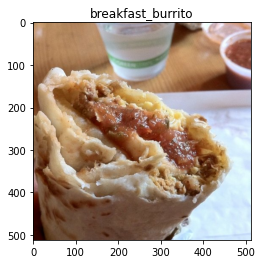

In [12]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])

In [13]:
#preprocessing function
"""network preformefd well when data is in this format:
batched normalized etc"""
def preprocessed_img(image,label,img_shape=224):
  image=tf.image.resize(image,[img_shape,img_shape])
  image= image/255
  return tf.cast(image,tf.float32),label


In [14]:
preprocessed=preprocessed_img(image,label)[0]
print(f"image before preprocessing :\n {image[:2]}...,\nshape :{image.shape},\nDatatype: {image.dtype},\n")
print(f"image after preprocessing :\n {preprocessed[:2]}...,\nshape :{preprocessed.shape},\nDatatype: {preprocessed.dtype},\n")

image before preprocessing :
 [[[126 102  68]
  [134 108  73]
  [145 117  80]
  ...
  [213 183 185]
  [209 179 179]
  [199 169 169]]

 [[114  90  56]
  [127 101  66]
  [145 117  80]
  ...
  [215 185 187]
  [210 180 182]
  [200 170 172]]]...,
shape :(512, 512, 3),
Datatype: <dtype: 'uint8'>,

image after preprocessing :
 [[[0.49213684 0.39297718 0.25712287]
  [0.6227291  0.49835935 0.3459784 ]
  [0.7191076  0.5636454  0.39585835]
  ...
  [0.8678071  0.75408155 0.77258897]
  [0.84267706 0.7226891  0.7375549 ]
  [0.80812186 0.6904748  0.6955168 ]]

 [[0.49223688 0.39307722 0.2572229 ]
  [0.65400165 0.5217887  0.37332934]
  [0.74105644 0.58559424 0.41780713]
  ...
  [0.8906566  0.76930803 0.8006806 ]
  [0.87701076 0.7596438  0.79017603]
  [0.84565675 0.73219174 0.7613233 ]]]...,
shape :(224, 224, 3),
Datatype: <dtype: 'float32'>,



In [15]:
image[156].shape

TensorShape([512, 3])

In [16]:
#map preprocessing function
train_data=train_data.map(map_func=preprocessed_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [17]:
#maping data test data
test_data = test_data.map(preprocessed_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [18]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [19]:
from helper import create_tensorboard_callback
checkpoint_path="model_checkpoints/cp.ckpt"
model_checkpoint =tf.keras.callbacks.ModelCheckpoint(checkpoint_path,monitor="val_acc",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0)


In [20]:
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

In [21]:
#moxed precesion utilizes a combination of float32 and float16 to speed up model preformance
#it is not comapctable to collab gpu like k80, p100 compactable to Tesla T4
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape= (224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

In [23]:
inputs = layers.Input(shape=input_shape,name="input_layer")
x=base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs )

In [24]:

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [26]:
mixed_precision.global_policy

<function keras.mixed_precision.policy.global_policy>

In [ ]:
history_food=model.fit(train_data,epochs=3,steps_per_epoch=(len(train_data)),
                       validation_data=test_data,
                       validation_steps=int(0.15*len(test_data)),
                       callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                              experiment_name="efficientb0"),
                       model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientb0/20210828-020003
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
